In [1]:
#Program Name: hw3.ipynb
#Date Created: October 30th, 2022
#Author: Deepesh Verma (dbv293)

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 

In [118]:
#Allen-Cahn Equation Solver
from scipy.integrate import solve_ivp

class AllenCahn:
    """
    Implementation of the Allen-Cahn equation in 2D, usnig the method of lines and explicit finite differences.

    Parameters: 
        nx: number of x grid points
        ny: number of y grid points
        kappa: reaction rate 
        d: diffusion coefficient
        Lx: length of the domain in the x-direction 
        Ly: length of the domain in the y-direction
    """

    def __init__(self,nx,ny,kappa = 1.0,d = 1.0, Lx = 1.0, Ly = 1.0):
        """
        Initializes parameters for the method of lines calculation. 
        """
        #Sets parameters.
        self.nx = nx 
        self.ny = ny 
        self.dx = Lx/nx 
        self.dy = Ly/ny 
        self.d = d 
        self.kappa = kappa 

    def _laplace(self,grid):
        """
        Applies the 2D Laplace operator to a square array. 
        """
        #Sets reflection boundary conditions. (No idea how this does that...)
        grid = np.vstack([grid[0, :][None, :], grid, grid[-1, :][None, :]])
        grid  = np.hstack([grid[:, 0][:, None], grid, grid[:, -1][:, None]])

        #Initializes and populates the Laplacian 
        lap = np.zeros((self.ny, self.nx))
        lap = grid[:-2, 1:-1] + grid[1:-1, :-2] + grid[2:, 1:-1] + grid[1:-1, 2:]
        #lap[1:-1, 1:-1] = grid[:-2, 1:-1] + grid[1:-1, :-2] + grid[2:, 1:-1] + grid[1:-1, 2:]
        lap -= 4*grid[1:-1,1:-1]
        lap /= self.dx*self.dy

        return lap

    def _reaction(self,y):
        """ 
        Bistable reaction term. 
        """
        return y*(1-y**2)

    def rhs(self,t,y): 
        """ 
        Calculates the right hand side (rhs) of the Allen-Cahn equation.
        """
        y = y.reshape((self.ny, self.nx))
        out = self.kappa * self._reaction(y) + self.d * self._laplace(y)
        return out.flatten()


    def solve(self,y0,t_min,t_max,nt,**kwargs):
        """ 
        Solves the heat equation using solve_ivp. 

        Inputs: 
            y0: Initial values at t=tmin. 
            tmin: Initial time value.
            tmax: Final tiime value. 
            nt: number of discrete time intervals
        """
        #Establishes points in time. 
        tpts = np.linspace(t_min,t_max,nt)
        out = solve_ivp(self.rhs,(t_min,t_max),y0.flatten(),t_eval=tpts,**kwargs)
        sol = out.y.T
        tpts = out.t
        return tpts, sol.reshape((len(tpts), self.ny, self.nx))


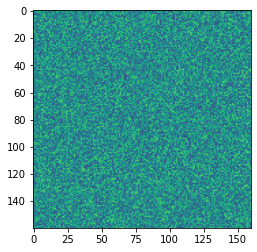

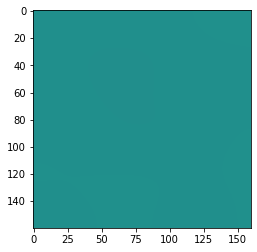

In [154]:
#Runs Allen-Cahn equation solver on random sample of data. 
np.random.seed(0)
ic = np.random.random((160, 160)) - 0.5
model = AllenCahn(*ic.shape, kappa=0, d=1e-3)
tpts, sol = model.solve(ic, 0, 10, 400, method="DOP853")

plt.figure()
plt.imshow(sol[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol[-1], vmin=-1, vmax=1)


In [155]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(sol[i], vmin=-1, vmax=1, cmap="coolwarm")
    plt.show()

interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(sol) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=399), Output()), _…

<function __main__.plotter(i)>

In [156]:
#Questions to Part I 

#Q2: When decreasing d we see that there is still a lot of "noise" even after a large passage of time. As we increase k we see that the shapes of the
#regions remain the same, although there definitely are more distinct areas of "hot" and "cool".

#Q3: For smaller time steps we have more fine progression of the flow of heat through time. For small mesh sizes we have a very pixelated image, and
#for large meshes we have smooth shapes. For very large time durations we see our system reach an equilibrium where there is a cold half and warm 
#half of the space. 

#Q4: Hmmm good question.

In [174]:
#Gray-Scott Model 

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model

    Parameters
        nx: number of grid points in the x direction
        ny: number of grid points in the y direction
        Lx: length of the domain in the x direction
        Ly: length of the domain in the y direction
        du: diffusion coefficient for u
        dv: diffusion coefficient for v
        kappa: degradation rate of v
        b: growth rate of u

    """

    def __init__(self, nx, ny, du=0.1, dv=0.02, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        """
        Initializes parameters for the method of lines calculation of Gray-Scott. 
        """
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        #Defines the mesh for frequency domain.
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq

    def _reaction(self,y):
        """ 
        Compute the reaction term in real space. 

        Inputs: 
            y: array of shape 2*nx*ny containing the 2 fields u and v, stacked together, repsectively. 

        Outputs:
            y_out: array of shape 2*nx*ny containing thee reaction terms for u and v, stacked together respectively. 
        """

        u,v=y[:(self.ny*self.nx)],y[-(self.ny*self.nx):]
        uv2 = u*(v**2)
        rxn_u = -uv2 +self.b*(1-u)
        rxn_v = uv2 -self.kappa*v
        y_out = np.hstack([rxn_u,rxn_v])
        return y_out

    def _laplace(self,y): 
        """ 
        Calculation of the Laplacian in Fourier space. 
        """
        #Reshapes the vector array y into a matrix array, size nx*ny.
        y = np.reshape(y,(self.nx,self.ny))
        #Computes the 2D discrete Fourier tranform of y. 
        yk = np.fft.fft2(y)
        lap = -self.ksq*yk
        #Performs the 2D discrete inverse Fourier transform. 
        lap = np.fft.ifft2(lap)
        return np.real(lap).flatten()

    def _diffusion(self,y):
        """
        Calculation of the diffusion term in Fourier space. 
        """
        u,v=y[:(self.ny*self.nx)],y[-(self.ny*self.nx):]

        #Calculates the Laplacian in Fourier space of u and v. 
        lap_u = self._laplace(u)
        lap_v = self._laplace(v)

        u_out = self.du*lap_u
        v_out = self.dv*lap_v

        y_out = np.hstack([u_out,v_out])
        return y_out

    def rhs(self,t,y):
        """ 
        Calculates the right hand side (rhs) of the Gray-Scott model. 
        """
        out = self._reaction(y) + self._diffusion(y)
        return out

    def solve(self,y0,t_min,t_max,nt, **kwargs):
        """
        Solves the Gray-Scott model using solve_ivp.
            
        Parameters:
            y0: initial condition
            t_min: initial time
            t_max: final time
            nt: number of time steps
        """

        #Initializes y0 by stacking the initial fields u0 and v0
        u0,v0 = y0

        #Initializes an array with each time step. 
        tpts = np.linspace(t_min,t_max,nt)

        y0 = np.hstack([u0.flatten(), v0.flatten()])
        out = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval=tpts, **kwargs)
        sol = out.y.T
        
        u, v = sol[:, :self.nx * self.ny], sol[:, self.nx * self.ny:]
        u = np.reshape(u, (nt, self.ny, self.nx))
        v = np.reshape(v, (nt, self.ny, self.nx))
        return tpts, np.stack([u, v], axis=-1)



Imaginary residual is: 0.0


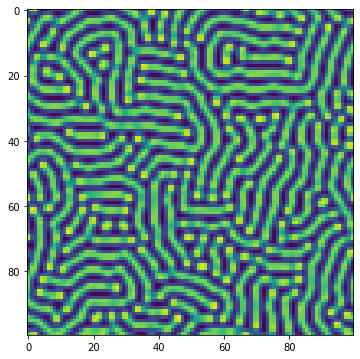

In [175]:
#Tests the Gray-Scott Model 

#Makes random initial conditions.
np.random.seed(0)
u_ic = 0.5 +  1.5 * np.random.random((100, 100))
v_ic = 1 - np.copy(u_ic)

#Performs Gray-Scott Simulations
model = GrayScott(*u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

#Check of imaginary residual (should be small).
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

In [176]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(sol[i, ..., 1])
    plt.show()



interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(sol) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=499), Output()), _…

<function __main__.plotter(i)>

In [ ]:
#Questions for Part II 

#Q1: Something very interestinig seems to happen for du = 0.05, something seems to break, just a black and yellow grid. For smaller and smaller dv the
#bright green lines seems to get more compact within the plane. Their thickness remains the same. They follow trends but the changes were not obvious
#to me initially when changing the parameters.